# This notebook loads trajectories of a Kerr system in the qubit regime and applies machine learning algorithms to learn about the manifold the trajectory spans.

In [1]:
import sys
sys.version

'2.7.12 |Anaconda 2.4.1 (x86_64)| (default, Jun 29 2016, 11:09:23) \n[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]'

In [2]:
Regime = "kerr_qubit" ## used to load appropraite file

#  loading trajectory and using manifold my diffusion map script.

In [3]:
## load trajectory data from file
import pickle

## diffusion maps
from diffusion_maps import run_diffusion_map

## numerical
import numpy as np

## plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

In [4]:
def show_colorbar(x_index, name):
    ## show color scheme
    # http://matplotlib.org/examples/color/colormaps_reference.html

    gradient = np.linspace(0, 1, x_index)
    gradient = np.vstack((gradient, gradient))

    fig, axes = plt.subplots(figsize=(24,2))
    axes.set_title( ' colormaps', fontsize=14)
    axes.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))

    plt.show()

In [5]:
def colored_3d_plot(data_ltsa_):
    ## Figure 
    fig = plt.figure(figsize=(24,20))
    ax = fig.add_subplot(111, projection='3d')
    to_plot_=[[x[i] for x in data_ltsa_] for i in xrange(0,3)]

    x_index = len(np.asarray(to_plot_).T)/params['Ntraj']

    color_list = np.concatenate([np.linspace(0, 1, x_index)] * params['Ntraj'])
    colors = cm.jet(color_list)
    ax.scatter(*to_plot_,c=colors)

    show_colorbar(x_index,'jet')

## Diffusion maps

### New format

In [5]:
## load trajectory data from file

pkl_file = open('./make_quantum_jump_trajectories/trajectory_data/'+ Regime +'.pkl', 'rb')
pkl_dict = pickle.load(pkl_file)
pkl_file.close()

## pre-process expectation values

traj_expects = np.concatenate(pkl_dict['expects']).real.T

## some useful numbers

Ntraj = pkl_dict['Ntraj']
duration = pkl_dict['duration']

##  Extract data into points of format (psi.real,psi.imag) from all trajectories.

traj_data = np.concatenate(
            [[ np.concatenate([f(pkl_dict['psis'][traj_num][time_num]) 
                for f in (lambda x: x.real, lambda x: x.imag) ]) 
                    for traj_num in range(Ntraj)]
                        for time_num in range(int(duration))])

In [6]:
## Paramters to use

diffusion_params = {}

diffusion_params["gaussian_epsilon"] = 0.2 ## width of Gaussian kernel.
diffusion_params["num_neighbors"] = 200 ## cutoff of number of neighbors, if using epsilon_cutoff
diffusion_params["alpha"] = 1. ## coefficient to use for diffusion maps. See the wikipedia article.

diffusion_params["data_size"] = 5000 ## total number of points
diffusion_params["eigen_dims"] = 4 ## number of lower dimensions to consider, i.e. number of eigenvectors to find.

In [7]:
traj1 = traj_data[::(len(traj_data)/diffusion_params["data_size"])]
Nfock = pkl_dict['Nfock']

In [8]:
## Using the euclidean (default) metric

e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                   diffusion_params,
                                   symmetric=True,
                                   neighbor_selection = "num_neighbors")

using num_neighbors  


## The shape above resembles the Hopf fibration. This can be explained if the states with the global phase removed lie on a circle on the Bloch sphere. See http://nilesjohnson.net/hopf.html

## Next, let's color the same plot by the photon number.

In [27]:
def plot_by_operator(data,traj1,operator = "photon_num"):
    
    if operator == "photon_num":
        num = np.asmatrix(np.diag([i for i in range(Nfock)]*2))
        num_expects = np.asarray([(i*num*i.T)[0,0] for i in np.asmatrix(traj1)])
    else:
        raise ValueError("operator type not implemented")
       
    ## sort data by expected photon number
    num_expects_indices = [(i,n) for i,n in enumerate(num_expects)]
    sorted_num_expects = sorted(num_expects_indices, key = lambda z: z[1])
    data_by_num = [data[i[0]] for i in sorted_num_expects]

    ## Figure 
    fig = plt.figure(figsize=(24,20))
    ax = fig.add_subplot(111, projection='3d')
    to_plot_=[[x[i] for x in data_by_num] for i in xrange(0,3)]

    ## color bar
    x_index = len(np.asarray(to_plot_).T)
    color_list = np.concatenate([np.linspace(0, 1, x_index)] )
    colors = cm.jet(color_list)
    ax.scatter(*np.asarray(to_plot_),c=colors)
    show_colorbar(x_index,'jet')

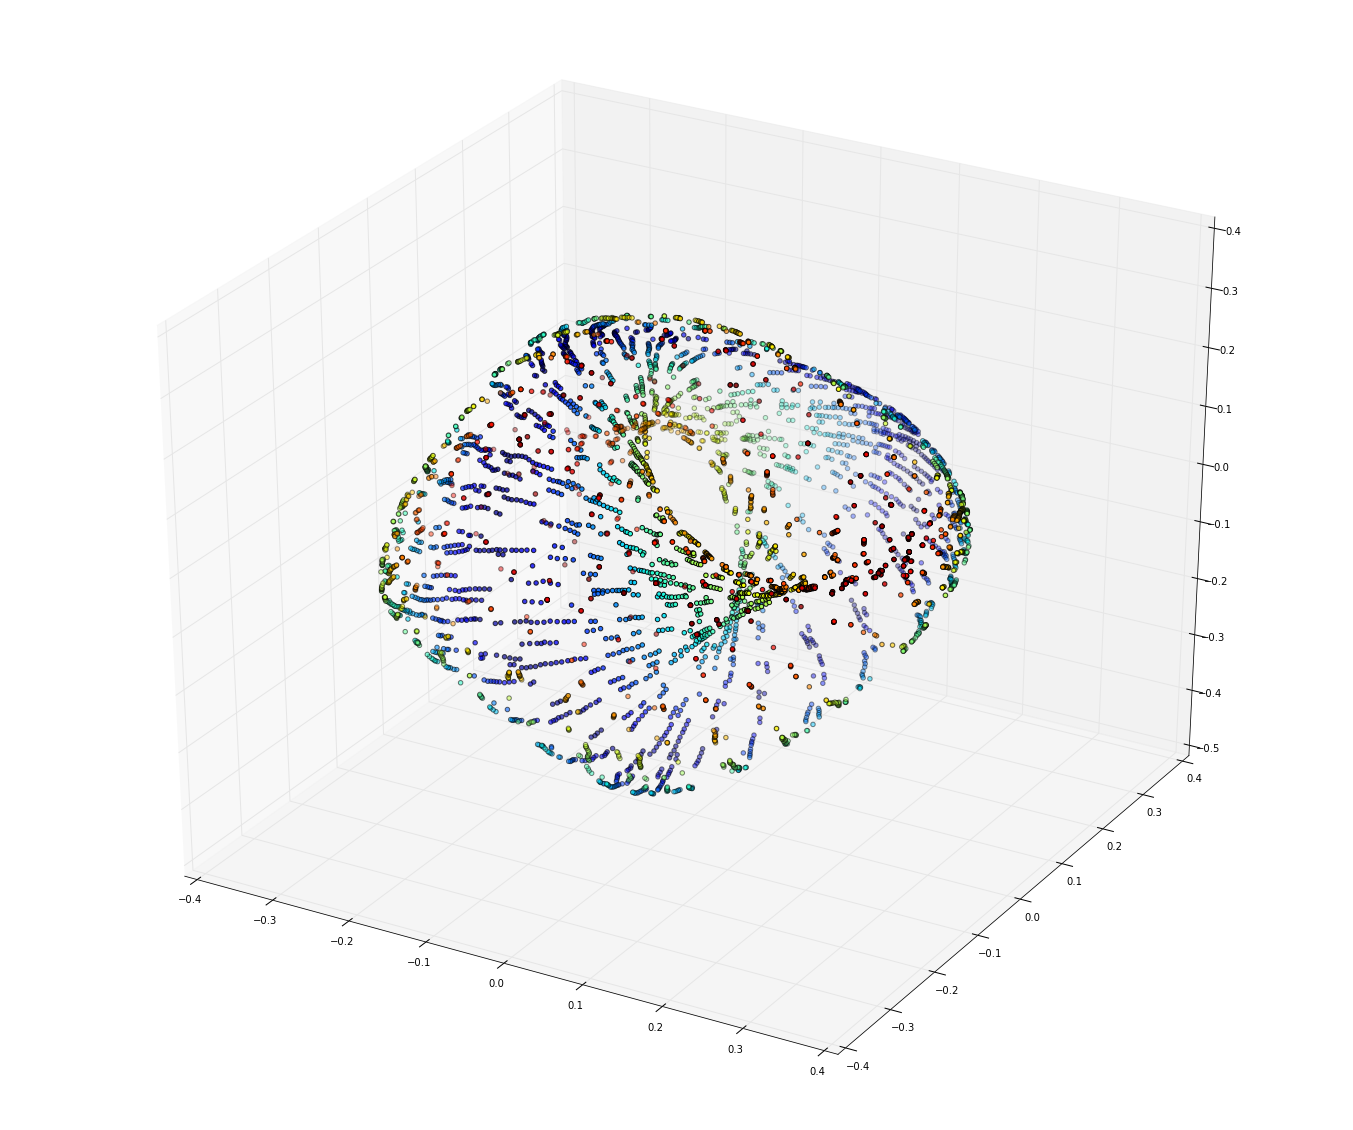

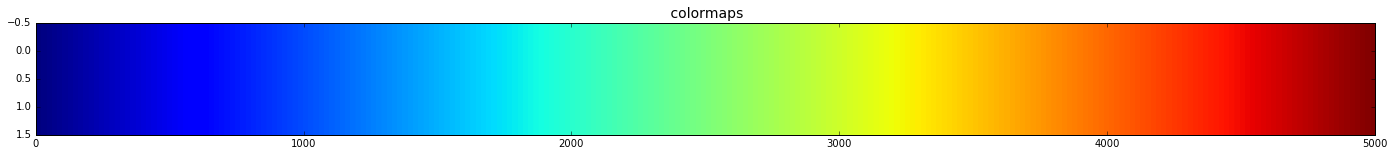

In [28]:
plot_by_operator(e_vecs.T[1:].T,traj1)

# Fubini-Study metric below!

In [29]:
## Using the euclidean (default) metric
diffusion_params["eigen_dims"] = 4 ## number of lower dimensions to consider, i.e. number of eigenvectors to find.

e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                   diffusion_params,
                                   symmetric=True,
                                   metric = "FS_metric",
                                   neighbor_selection = "num_neighbors")

using num_neighbors  


## Color by photon number

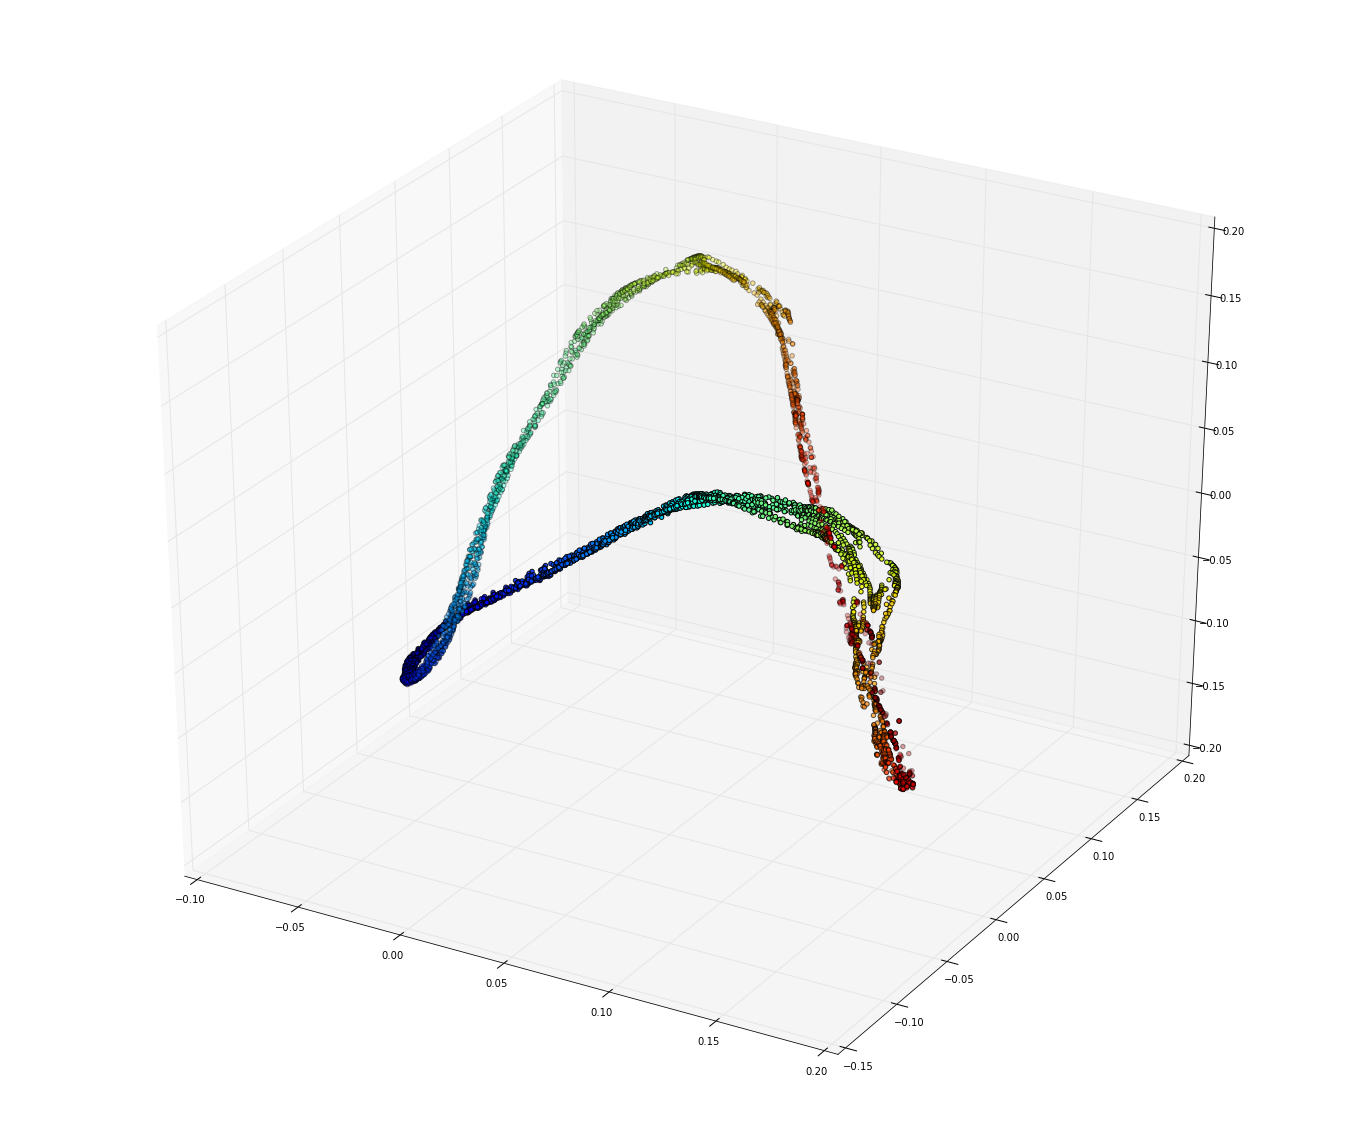

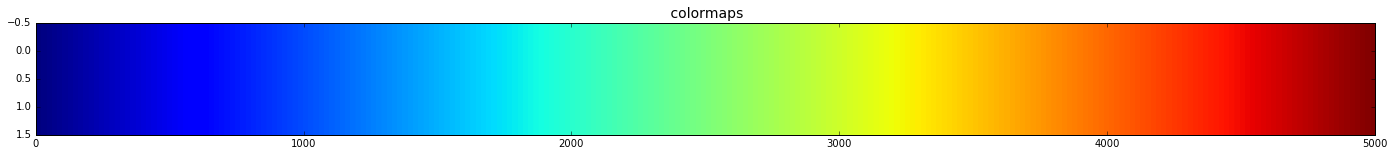

In [30]:
plot_by_operator(e_vecs.T[1:].T,traj1)

# Comments:

## We have shown that using the FS metric, the underlying geometry of a Kerr in the qubit limit can be found. We demonstrated that this geometry results in a circle. This result is consistent with the torus obtained by using the Euclidean geometry, since it is the Hopf fibration corresponding to a circle in the Bloch sphere. In particular, this is the equatorial circle with respect to the 0 and 1 states. The steady state over many trajectories must result in this cricle since the density matrix in steady state becomes a mixture of 0 and 1 states.

## The advantage of using this example is that we can gain intuition as to how diffusion maps will behave on the quantum states with the metric given by the Fubini Study norm. In particular, the value chosen for the `gaussian_epsilon`, and either the `num_neighbors` or the `epsilon_cutoff` (depending on the mode of the diffusion map algorithm)  may be important.